### 5) 10K Ising

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch

import dimod
from neal.sampler import SimulatedAnnealingSampler

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=20)

In [2]:
# Spin encoding

def binary_to_spin(binary):    
    return binary * 2 - 1

def spin_to_binary(spin):    
    return (spin + 1) // 2


# Bit encoding

def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output


# One Hot encoding

def integer_to_one_hot(integer, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    number_bytes = np.array([integer], dtype=dtype)

    integer_view = number_bytes.view('uint8')
    
    bits = np.unpackbits(integer_view)
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


def one_hot_to_integer(one_hot_bits, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    decoding_scheme = {value: key for key, value in one_hot_scheme.items()}
    
    bits = []
        
    for one_hot_pair in one_hot_bits.reshape(-1, 2):
        
        bit = decoding_scheme[tuple(one_hot_pair)]
        
        bits.append(bit)
        
    bits_array = np.array(bits, dtype=dtype)    
   
    return bits_array


def bits_to_one_hot(bits, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


# Coupling coefficients

def get_coupling_coefficients(coupling_matrix):
    
    '''Convert matrix of Coupling coefficients to dictionary of weights'''
    
    coupling_coefficients = dict()
    
    for row_index, row in enumerate(coupling_matrix):
        
        # print(row[row_index:])
        
        for column_index, cell in enumerate(row[row_index:], row_index):
            
            coupling_coefficients[row_index, column_index] = cell
            
    return coupling_coefficients


# Correct One Hot

def is_correct_one_hot(record, one_hot_scheme=None):
    
    sample = record.sample
    
    fields_spins = np.array(list(sample.values()))
    
    fields_one_hot = spin_to_binary(fields_spins)
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    for one_hot_pair in fields_one_hot.reshape(-1, 2):
        
        one_hot_tuple = tuple(one_hot_pair)
        
        if one_hot_tuple not in one_hot_scheme.values():            
            
            return False
    
    return True


# Sample to Value

def sample_to_value(sample):    

    fields_spins = np.array(list(sample.values()))

    fields_one_hot = spin_to_binary(fields_spins)

    fields_bits = one_hot_to_integer(fields_one_hot)

    fixed_part = fields_bits[FIXED_BITS_COUNT:]

    value = decode_from_bits(fixed_part)
    
    # print("fields_spins:", fields_spins)
    # print("fields_one_hot:", fields_one_hot, fields_one_hot.shape)
    # print("fields_bits:", fields_bits, fields_bits.shape)
    # print("fixed_part:", fixed_part, fixed_part.shape)

    return value

In [3]:
# 1) One-hot penalization

EXAMPLE_INITIAL_STOCK_PRICE = 15
EXAMPLE_VOLATILITY = 0.5

FIXED_BITS_COUNT = 32 + 8
VARIABLE_BITS_COUNT = 32

PENALTY_VALUE = 50

MAXIMIZE = True


fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

example_volatility_percent = EXAMPLE_VOLATILITY * 100

In [4]:
# 2) Load weights

# FM_100K_PATH = 'saved_models/factorization_machine_100K_144_embeddings.pt'
# FM_100K_PATH = 'saved_models/factorization_machine_100K_16_embeddings.pt'

# FM_100K_PATH = 'saved_models/fm_assets_10K_144_embeddings_quad_root.pt'
FM_100K_PATH = 'saved_models/fm_assets_10K_144_embeddings_normalized.pt'
# FM_100K_PATH = 'saved_models/fm_assets_10K_144_embeddings.pt'

state_dict = torch.load(FM_100K_PATH)

loaded_factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
loaded_component_weights = state_dict['linear.fc.weight'].numpy().squeeze()
loaded_global_bias = state_dict['linear.bias'].numpy().squeeze()

loaded_factorization_matrix.shape, loaded_component_weights.shape, loaded_global_bias.shape

((144, 144), (144,), ())

In [5]:
# 3) Variable fields penalty

one_hot_pair_penalty = [[-PENALTY_VALUE, 2 * PENALTY_VALUE],
                        [2 * PENALTY_VALUE, -PENALTY_VALUE]]

penalization_matrix = np.zeros((total_one_hot_bits_count, total_one_hot_bits_count), dtype=int)

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalization_matrix[offset : offset + 2,
                        offset : offset + 2] = one_hot_pair_penalty
    
print("penalization_matrix part:\n", penalization_matrix[-4:, -4:])

penalization_matrix part:
 [[-50 100   0   0]
 [100 -50   0   0]
 [  0   0 -50 100]
 [  0   0 100 -50]]


In [6]:
# 4) Fixed fields penalty

encoded_initial_stock_price = encode_to_bits(EXAMPLE_INITIAL_STOCK_PRICE, 
                                             dtype='>f', bits_count=32)

encoded_volatility = encode_to_bits(example_volatility_percent, 
                                    dtype='>i1', bits_count=8)

example_input = np.hstack((encoded_initial_stock_price, encoded_volatility)).squeeze()

one_hot_fields = bits_to_one_hot(example_input)

fixed_part_vector = -1 * binary_to_spin(one_hot_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

penalization_vector = np.concatenate((fixed_part_vector, variable_part_vector))

print("example_input:\n", example_input)
print("one_hot_fields:\n", one_hot_fields)
print("penalization_vector:\n", penalization_vector)

example_input:
 [0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 0]
one_hot_fields:
 [0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1
 0 1 1 0 0 1]
penalization_vector:
 [ 50 -50 -50  50  50 -50  50 -50  50 -50  50 -50  50 -50 -50  50  50 -50
 -50  50 -50  50 -50  50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50
  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50
  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50 -50  50 -50  50
  50 -50  50 -50 -50  50  50 -50   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [7]:
# 5) Quadratic

factorization_matrix = loaded_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

if MAXIMIZE:
    
    coupling_matrix = -coupling_matrix

penalized_coupling_matrix = coupling_matrix + penalization_matrix

coupling_coefficients = get_coupling_coefficients(penalized_coupling_matrix) 


# Printouts

print("factorization_matrix:\n", factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix.shape)
print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
print("coupling_coefficients part:\n", coupling_coefficients.__repr__()[-60:])

factorization_matrix:
 (144, 144)
coupling_matrix:
 (144, 144)
penalized_coupling_matrix part:
 [[-52.17901611  -0.36352256   0.26941952]
 [ -0.36352256 -54.07810068 100.48624119]
 [  0.26941952 100.48624119 -52.51575422]]
coupling_coefficients part:
 42, 143): 100.4862411916256, (143, 143): -52.51575422286987}


In [8]:
# 6) Linear

component_weights = loaded_component_weights

if MAXIMIZE:
    
    component_weights = -component_weights

penalized_component_weights = component_weights + penalization_vector

component_coefficients = dict(enumerate(penalized_component_weights))

print("component_weights.shape:\n", component_weights.shape)
print("penalization_vector:\n", penalization_vector)
print("penalized_component_weights.shape:\n", penalized_component_weights.shape)

component_weights.shape:
 (144,)
penalization_vector:
 [ 50 -50 -50  50  50 -50  50 -50  50 -50  50 -50  50 -50 -50  50  50 -50
 -50  50 -50  50 -50  50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50
  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50
  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50  50 -50 -50  50 -50  50
  50 -50  50 -50 -50  50  50 -50   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
penalized_component_weights.shape:
 (144,)


In [9]:
# 7) Bias

global_bias = loaded_global_bias

if MAXIMIZE:
    
    global_bias = -global_bias
    
print("global_bias:\n", global_bias)

global_bias:
 0.6949992


In [10]:
# 8) BQM  

quadratic = coupling_coefficients

linear = component_coefficients

offset = global_bias

variable_type = dimod.SPIN

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, variable_type)

sampler = SimulatedAnnealingSampler()

# sampler = dimod.ExactSolver()

# qubo = dimod.utilities.ising_to_qubo(linear, quadratic, offset)

In [11]:
# 9) Run

shots_count = 1000

results = sampler.sample(model, num_reads=shots_count)

aggregated_results = results.aggregate()


# 10) Results

filtered_results = aggregated_results.filter(pred=is_correct_one_hot)

print("results:", len(results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

results: 1000
aggregated_results: 1000
filtered_results: 5


In [12]:
# 11) Top Option Prices

top_record = filtered_results.first

top_sample = top_record.sample

top_asset_price = sample_to_value(top_sample)


top_samples = filtered_results.samples(n=10)

top_asset_prices = []

for top_sample in top_samples:
    
    top_value = sample_to_value(top_sample)
    
    top_asset_prices.append(top_value.item())
    
top_asset_prices = np.array(top_asset_prices)


print("Example initial stock price:", EXAMPLE_INITIAL_STOCK_PRICE)
print("Example volatility:", EXAMPLE_VOLATILITY)
print("example_volatility_percent:", example_volatility_percent)
print("Task:", ['Minimize', 'Maximize'][MAXIMIZE])
print("Top asset price:", top_asset_price)
print("Top asset prices:", top_asset_prices)

Example initial stock price: 15
Example volatility: 0.5
example_volatility_percent: 50.0
Task: Maximize
Top asset price: [1.3847554e-19]
Top asset prices: [ 1.38475540e-19  2.63584280e+00  3.19127508e-39  2.50382781e+00
 -1.19080079e+10]


### 6) Ising Energies

In [13]:
# Encode dataset

ASSET_DATASET_PATH = 'simulated_prices/asset_prices_10K.csv'

PENALIZED = False


data = pd.read_csv(ASSET_DATASET_PATH)

encoded_initial_asset_prices = encode_to_bits(data.initial_asset_price, 
                                              dtype='>f', bits_count=32)

volatility_percents = data.volatility * 100

encoded_volatility_percents = encode_to_bits(volatility_percents,
                                             dtype='i1', bits_count=8)

encoded_asset_prices = encode_to_bits(data.asset_price, 
                                      dtype='>f', bits_count=32)

encoded_dataset_array = np.hstack((encoded_initial_asset_prices,
                                   encoded_volatility_percents,
                                   encoded_asset_prices))

encoded_dataset_array.shape


energies = []

for row_bits in encoded_dataset_array:  
    
    one_hot_row = bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))
    
    if PENALIZED:
        
        energy = dimod.utilities.ising_energy(sample, h=linear, J=quadratic, offset=offset)        
    
    else:
        
        component_coefficients = dict(enumerate(component_weights))

        not_penalized_coupling_coefficients = get_coupling_coefficients(coupling_matrix) 

        energy = dimod.utilities.ising_energy(sample, 
                                              h=component_coefficients, 
                                              J=not_penalized_coupling_coefficients, 
                                              offset=offset)
    
    energies.append(energy)

In [14]:
# Import predictions

# ASSET_PREDICTIONS_PATH = 'predictions/10k_predictions.xlsx'

ASSET_PREDICTIONS_PATH = 'predictions/10k_predictions_normalized.xlsx'


predictions_dataframe = pd.read_excel(ASSET_PREDICTIONS_PATH)

targets = predictions_dataframe['Targets']
predictions = predictions_dataframe['Predictions']

targets

0     -0.112896
1     -0.113009
2     -0.112557
3     -0.112670
4     -0.111878
         ...   
995   -0.113122
996   -0.113122
997   -0.113122
998   -0.113009
999   -0.113009
Name: Targets, Length: 1000, dtype: float64

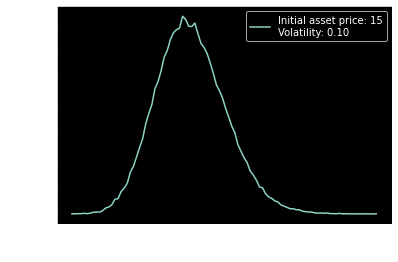

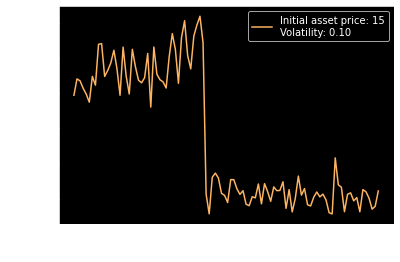

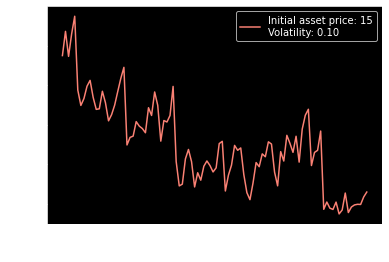

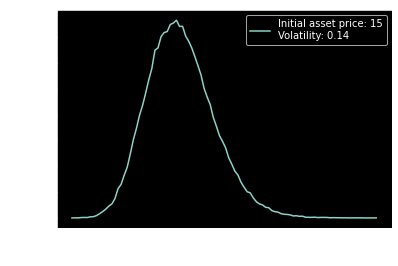

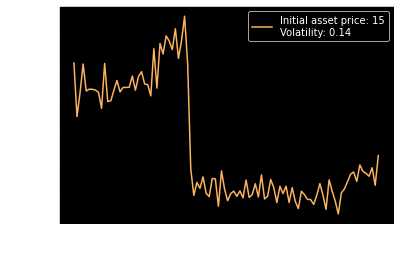

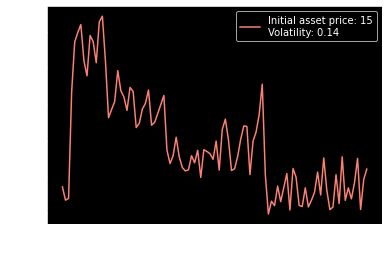

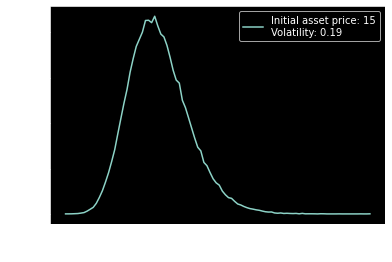

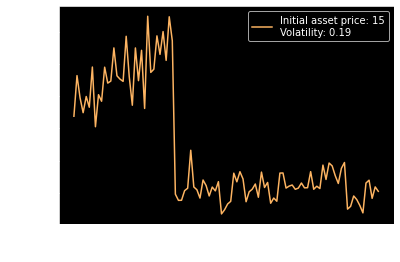

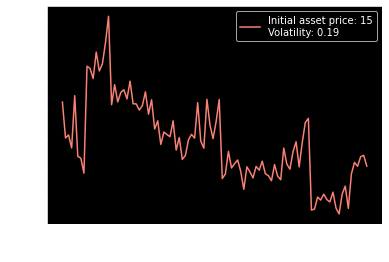

In [15]:
slice_size = 100
slices_count = len(data) // slice_size

slice_indices = range(0, 3)


for slice_index in slice_indices:

    data_slice = slice(slice_index * slice_size, 
                       slice_index * slice_size + slice_size)

    label = f"Initial asset price: {data.initial_asset_price[data_slice].mean():.00f}\n" \
            f"Volatility: {data.volatility[data_slice].mean():.02f}"

    plt.plot(data.asset_price[data_slice], data.probability[data_slice], label=label)

    plt.xlabel("Asset price")
    plt.ylabel("Monte-Carlo Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], predictions[data_slice], label=label, color='#fdb462')

    plt.xlabel("Asset price")
    plt.ylabel("Predicited Probability")
    plt.legend()
    plt.show()
    
    plt.plot(data.asset_price[data_slice], -np.array(energies[data_slice]), label=label, color='#fa8174')

    plt.xlabel("Asset price")
    plt.ylabel("Minus Energy")
    plt.legend()
    plt.show()

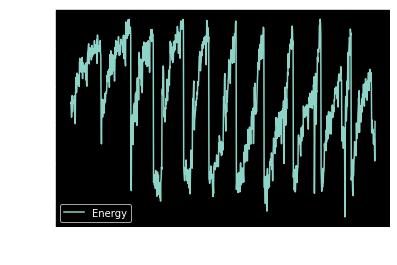

In [16]:
plt.plot(energies[-1000:], label="Energy")

plt.xlabel("Sample")
plt.ylabel("Energy")
plt.legend()
plt.show()

### 4) 100M Ising

In [146]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch

import dimod
from neal.sampler import SimulatedAnnealingSampler

plt.style.use('dark_background')

dimod.serialization.format.set_printoptions(width=110, depth=10)

In [20]:
# Spin encoding

def binary_to_spin(binary):    
    return binary * 2 - 1

def spin_to_binary(spin):    
    return (spin + 1) // 2


# Bit encoding

def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output


# One Hot encoding

def integer_to_one_hot(integer, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    number_bytes = np.array([integer], dtype=dtype)

    integer_view = number_bytes.view('uint8')
    
    bits = np.unpackbits(integer_view)
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


def one_hot_to_integer(one_hot_bits, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    decoding_scheme = {value: key for key, value in one_hot_scheme.items()}
    
    bits = []
        
    for one_hot_pair in one_hot_bits.reshape(-1, 2):
        
        bit = decoding_scheme[tuple(one_hot_pair)]
        
        bits.append(bit)
        
    bits_array = np.array(bits, dtype=dtype)    
   
    return bits_array


def bits_to_one_hot(bits, dtype='>i1', one_hot_scheme=None): 
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    return one_hot_array


# Coupling coefficients

def get_coupling_coefficients(coupling_matrix):
    
    '''Convert matrix of Coupling coefficients to dictionary of weights'''
    
    coupling_coefficients = dict()
    
    for row_index, row in enumerate(coupling_matrix):
        
        # print(row[row_index:])
        
        for column_index, cell in enumerate(row[row_index:], row_index):
            
            coupling_coefficients[row_index, column_index] = cell
            
    return coupling_coefficients


# Correct One Hot

def is_correct_one_hot(record, one_hot_scheme=None):
    
    sample = record.sample
    
    fields_spins = np.array(list(sample.values()))
    
    fields_one_hot = spin_to_binary(fields_spins)
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    for one_hot_pair in fields_one_hot.reshape(-1, 2):
        
        one_hot_tuple = tuple(one_hot_pair)
        
        if one_hot_tuple not in one_hot_scheme.values():            
            
            return False
    
    return True


# Sample to Value

def sample_to_value(sample):    

    fields_spins = np.array(list(sample.values()))

    fields_one_hot = spin_to_binary(fields_spins)

    fields_bits = one_hot_to_integer(fields_one_hot)

    fixed_part = fields_bits[FIXED_BITS_COUNT:]

    value = decode_from_bits(fixed_part)
    
    # print("fields_spins:", fields_spins)
    # print("fields_one_hot:", fields_one_hot, fields_one_hot.shape)
    # print("fields_bits:", fields_bits, fields_bits.shape)
    # print("fixed_part:", fixed_part, fixed_part.shape)

    return value

In [21]:
# 1) One-hot penalization

EXAMPLE_INITIAL_STOCK_PRICE = 5000
EXAMPLE_VOLATILITY = 0.9

FIXED_BITS_COUNT = 32 + 8
VARIABLE_BITS_COUNT = 32

# LATENT_FACTORS_COUNT = 144
# EXAMPLE_WEIGHT_RANGE = (0, 10)

PENALTY_VALUE = 1.7

MAXIMIZE = True


random_generator = np.random.default_rng()

fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

example_volatility_percent = EXAMPLE_VOLATILITY * 100

In [22]:
# 2) Load weights

# FM_100M_PATH = 'saved_models/factorization_machine_100M.pt'
FM_100M_PATH = 'saved_models/factorization_machine_100M_144_embeddings.pt'

state_dict = torch.load(FM_100M_PATH)

loaded_factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
loaded_component_weights = state_dict['linear.fc.weight'].numpy().squeeze()
loaded_global_bias = state_dict['linear.bias'].numpy().squeeze()

loaded_factorization_matrix.shape, loaded_component_weights.shape, loaded_global_bias.shape

((144, 144), (144,), ())

In [23]:
# 3) Variable fields penalty

one_hot_pair_penalty = [[-PENALTY_VALUE, 2 * PENALTY_VALUE],
                        [2 * PENALTY_VALUE, -PENALTY_VALUE]]

penalization_matrix = np.zeros((total_one_hot_bits_count, total_one_hot_bits_count), dtype=int)

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalization_matrix[offset : offset + 2,
                        offset : offset + 2] = one_hot_pair_penalty
    
print("penalization_matrix part:\n", penalization_matrix[-4:, -4:])

penalization_matrix part:
 [[-1  3  0  0]
 [ 3 -1  0  0]
 [ 0  0 -1  3]
 [ 0  0  3 -1]]


In [24]:
# 4) Fixed fields penalty

# example_fields = random_generator.integers(0, 2, size=fixed_one_hot_bits_count)

encoded_initial_stock_price = encode_to_bits(EXAMPLE_INITIAL_STOCK_PRICE, 
                                             dtype='>f', bits_count=32)

encoded_volatility = encode_to_bits(example_volatility_percent, 
                                    dtype='>i1', bits_count=8)

example_input = np.hstack((encoded_initial_stock_price, encoded_volatility)).squeeze()

one_hot_fields = bits_to_one_hot(example_input)

fixed_part_vector = -1 * binary_to_spin(one_hot_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

penalization_vector = np.concatenate((fixed_part_vector, variable_part_vector))

print("example_input:\n", example_input)
print("one_hot_fields:\n", one_hot_fields)
print("penalization_vector:\n", penalization_vector)

example_input:
 [0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 1 0]
one_hot_fields:
 [0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0
 0 1 1 0 0 1]
penalization_vector:
 [ 1.7 -1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7
 -1.7  1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7
 -1.7  1.7 -1.7  1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

In [25]:
# 5) Quadratic

# random_factorization_matrix = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, 
#                                                  size=(total_one_hot_bits_count,
#                                                        LATENT_FACTORS_COUNT))

# factorization_matrix = random_factorization_matrix

factorization_matrix = loaded_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

if MAXIMIZE:
    
    coupling_matrix = -coupling_matrix

penalized_coupling_matrix = coupling_matrix + penalization_matrix

coupling_coefficients = get_coupling_coefficients(penalized_coupling_matrix) 


# Printouts

print("factorization_matrix:\n", factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix.shape)
print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
print("coupling_coefficients part:\n", coupling_coefficients.__repr__()[-60:])

factorization_matrix:
 (144, 144)
coupling_matrix:
 (144, 144)
penalized_coupling_matrix part:
 [[-1.14458306  0.0376703   0.0132046 ]
 [ 0.0376703  -1.16158374  3.03174204]
 [ 0.0132046   3.03174204 -1.38944489]]
coupling_coefficients part:
 2, 143): 3.0317420437932014, (143, 143): -1.389444887638092}


In [26]:
# 6) Linear   

# random_component_weights = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, size=total_one_hot_bits_count)

# component_weights = random_component_weights

component_weights = loaded_component_weights

if MAXIMIZE:
    
    component_weights = -component_weights

penalized_component_weights = component_weights + penalization_vector

component_coefficients = dict(enumerate(penalized_component_weights))

print("component_weights.shape:\n", component_weights.shape)
print("penalization_vector:\n", penalization_vector)
print("penalized_component_weights.shape:\n", penalized_component_weights.shape)

component_weights.shape:
 (144,)
penalization_vector:
 [ 1.7 -1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7
 -1.7  1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7
  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7
 -1.7  1.7 -1.7  1.7  1.7 -1.7 -1.7  1.7  1.7 -1.7  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0. ]
penalized_component_weights.shape:
 (144,)


In [27]:
# 7) Bias

# random_global_bias = random_generator.integers(*EXAMPLE_WEIGHT_RANGE)

# global_bias = random_global_bias

global_bias = loaded_global_bias

if MAXIMIZE:
    
    global_bias = -global_bias
    
print("global_bias:\n", global_bias)

global_bias:
 -0.06559295


In [28]:
# 8) BQM  

quadratic = coupling_coefficients

linear = component_coefficients

offset = global_bias

# variable_type = dimod.BINARY
variable_type = dimod.SPIN

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, variable_type)

# sampler = dimod.SimulatedAnnealingSampler()
sampler = SimulatedAnnealingSampler()

In [48]:
# 9) Run

shots_count = 1000

results = sampler.sample(model, num_reads=shots_count)

aggregated_results = results.aggregate()

# print(results)

In [53]:
# 10) Results

print("aggregated_results:\n", aggregated_results)

filtered_results = aggregated_results.filter(pred=is_correct_one_hot)

print("\nfiltered_results:\n", filtered_results)

aggregated_results:
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 ... 143      energy num_oc.
603 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  -1 -384.222608       1
497 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 +1 -1 -1 +1 +1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -383.421483       1
246 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 +1 -1 -1 +1 +1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -383.378961       1
896 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  -1 -383.354998       1
741 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -383.282787       1
219 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 -1 -1 -1 +1 -1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -383.111011       1
791 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 +1 -1 -1 +1 +1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -383.108791       1
633 -1 +1 +1 -1 -1 +1 -1 +1 -1 +1 +1 -1 -1 +1 +1 -1 +1 -1 -1 +1 -1 +1 +1 -1 +1 -1 ...  +1 -382.9529

In [51]:
# 11) Top Option Prices

top_record = filtered_results.first

top_sample = top_record.sample

top_option_price = sample_to_value(top_sample)


top_samples = filtered_results.samples(n=10)

top_option_prices = []

for top_sample in top_samples:
    
    top_value = sample_to_value(top_sample)
    
    top_option_prices.append(top_value.item())
    
top_option_prices = np.array(top_option_prices)


print("Example initial stock price:", EXAMPLE_INITIAL_STOCK_PRICE)
print("Example volatility:", EXAMPLE_VOLATILITY)
print("example_volatility_percent:", example_volatility_percent)
print("Task:", ['Minimize', 'Maximize'][MAXIMIZE])
print("Top option price:", top_option_price)
print("Top option prices:", top_option_prices)

Example initial stock price: 5000
Example volatility: 0.9
example_volatility_percent: 90.0
Task: Maximize
Top option price: [0.0286368]
Top option prices: [ 2.86367964e-02 -2.63791502e-01  6.52473993e-20  3.12142885e+19
  9.49962105e-22  4.57083797e-06  1.63022289e+27 -2.19134220e-26]


### Tiny FM Ising

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch

import dimod
from neal.sampler import SimulatedAnnealingSampler

In [2]:
# Spin encoding

def binary_to_spin(binary):    
    return binary * 2 - 1

def spin_to_binary(spin):    
    return (spin + 1) // 2


# Bit encoding

def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output


# One Hot encoding

def integer_to_one_hot(integer, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
    
    number_bytes = np.array([integer], dtype=dtype)

    integer_view = number_bytes.view('uint8')
    
    bits = np.unpackbits(integer_view)
    
    one_hot_bits = []
    
    for bit in bits:
        
        one_hot_pair = one_hot_scheme[bit]
        
        one_hot_bits.extend(one_hot_pair)
        
    one_hot_array = np.array(one_hot_bits, dtype=dtype)
    
    one_hot_8_bits = one_hot_array[-8:]
        
    # print("bits:", bits)    
    # print("one_hot_bits:", one_hot_bits)
    
    return one_hot_8_bits


def one_hot_to_integer(one_hot_bits, dtype='>i1', one_hot_scheme=None):    
    
    if one_hot_scheme is None:
        
        one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
    decoding_scheme = {value: key for key, value in one_hot_scheme.items()}
    
    bits = []
        
    for one_hot_pair in one_hot_bits.reshape(-1, 2):
        
        bit = decoding_scheme[tuple(one_hot_pair)]
        
        bits.append(bit)
        
    bits_array = np.array(bits, dtype=dtype)    
   
    return bits_array


# Coupling coefficients

def get_coupling_coefficients(coupling_matrix):
    
    '''Convert matrix of Coupling coefficients to dictionary of weights'''
    
    coupling_coefficients = dict()
    
    for row_index, row in enumerate(coupling_matrix):
        
        # print(row[row_index:])
        
        for column_index, cell in enumerate(row[row_index:], row_index):
            
            coupling_coefficients[row_index, column_index] = cell
            
    return coupling_coefficients

In [72]:
# One-hot penalization

EXAMPLE_INPUT = 1

FIXED_BITS_COUNT = 4
VARIABLE_BITS_COUNT = 1

LATENT_FACTORS_COUNT = 16
EXAMPLE_WEIGHT_RANGE = (0, 10)

PENALTY_VALUE = 0.001

MAXIMIZE = True


random_generator = np.random.default_rng()

fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

In [73]:
# Load weights

TINY_MODEL_PATH = 'saved_models/tiny_model.pt'

state_dict = torch.load(TINY_MODEL_PATH)

loaded_factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
loaded_component_weights = state_dict['linear.fc.weight'].numpy().squeeze()
loaded_global_bias = state_dict['linear.bias'].numpy().squeeze()

# loaded_factorization_matrix, loaded_component_weights, loaded_global_bias

In [74]:
# Variable fields penalty

one_hot_pair_penalty = [[-PENALTY_VALUE, 2 * PENALTY_VALUE],
                        [2 * PENALTY_VALUE, -PENALTY_VALUE]]

penalization_matrix = np.zeros((total_one_hot_bits_count, total_one_hot_bits_count), dtype=int)

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalization_matrix[offset : offset + 2,
                        offset : offset + 2] = one_hot_pair_penalty
    
print(penalization_matrix)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [75]:
# Fixed fields penalty

# example_fields = random_generator.integers(0, 2, size=fixed_one_hot_bits_count)

one_hot_fields = integer_to_one_hot(EXAMPLE_INPUT)

fixed_part_vector = -1 * binary_to_spin(one_hot_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

penalization_vector = np.concatenate((fixed_part_vector, variable_part_vector))

print("EXAMPLE_INPUT:\n", EXAMPLE_INPUT)
print("one_hot_fields:\n", one_hot_fields)
print("penalization_vector:\n", penalization_vector)

EXAMPLE_INPUT:
 1
one_hot_fields:
 [0 1 0 1 0 1 1 0]
penalization_vector:
 [ 0.001 -0.001  0.001 -0.001  0.001 -0.001 -0.001  0.001  0.     0.   ]


In [76]:
# Quadratic

random_factorization_matrix = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, 
                                                 size=(total_one_hot_bits_count,
                                                       LATENT_FACTORS_COUNT))

# factorization_matrix = random_factorization_matrix

factorization_matrix = loaded_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

if MAXIMIZE:
    
    coupling_matrix = -coupling_matrix

penalized_coupling_matrix = coupling_matrix + penalization_matrix

coupling_coefficients = get_coupling_coefficients(penalized_coupling_matrix) 


# Printouts

print("factorization_matrix:\n", factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix.shape)
print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
print("coupling_coefficients part:\n", coupling_coefficients.__repr__()[-60:])

factorization_matrix:
 (10, 16)
coupling_matrix:
 (10, 10)
penalized_coupling_matrix part:
 [[-1.26629722  0.46666664  0.43374214]
 [ 0.46666664 -1.12428081  0.11587713]
 [ 0.43374214  0.11587713 -1.4392581 ]]
coupling_coefficients part:
 01, (8, 9): 0.11587712913751602, (9, 9): -1.439258098602295}


In [77]:
# Linear   

random_component_weights = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, size=total_one_hot_bits_count)

# component_weights = random_component_weights

component_weights = loaded_component_weights

if MAXIMIZE:
    
    component_weights = -component_weights

penalized_component_weights = component_weights + penalization_vector

component_coefficients = dict(enumerate(penalized_component_weights))

print("component_weights:\n", component_weights)
print("penalization_vector:\n", penalization_vector)
print("penalized_component_weights:\n", penalized_component_weights)

component_weights:
 [ 0.08311421 -0.80015504  0.48323324 -0.26924106 -0.81753504 -0.23040316
 -0.7520253   0.33666626 -0.29938015 -0.6152688 ]
penalization_vector:
 [ 0.001 -0.001  0.001 -0.001  0.001 -0.001 -0.001  0.001  0.     0.   ]
penalized_component_weights:
 [ 0.08411421 -0.80115504  0.48423324 -0.27024106 -0.81653504 -0.23140316
 -0.75302531  0.33766626 -0.29938015 -0.61526883]


In [78]:
# Bias

random_global_bias = random_generator.integers(*EXAMPLE_WEIGHT_RANGE)

# global_bias = random_global_bias

global_bias = loaded_global_bias

if MAXIMIZE:
    
    global_bias = -global_bias
    
print("global_bias:\n", global_bias)

global_bias:
 0.13610579


In [79]:
# BQM  

quadratic = coupling_coefficients

linear = component_coefficients

offset = global_bias

# variable_type = dimod.BINARY
variable_type = dimod.SPIN

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, variable_type)

# sampler = dimod.SimulatedAnnealingSampler()
sampler = SimulatedAnnealingSampler()

In [80]:
# Run

shots_count = 10000

results = sampler.sample(model, num_reads=shots_count)

aggregated_results = results.aggregate()

# print(results)

In [81]:
print(aggregated_results)

   0  1  2  3  4  5  6  7  8  9     energy num_oc.
0 -1 +1 +1 +1 -1 +1 -1 -1 +1 +1 -21.843717    6550
1 +1 -1 -1 -1 +1 +1 +1 +1 -1 -1 -21.272844    3450
['SPIN', 2 rows, 10000 samples, 10 variables]


In [50]:
top_record = aggregated_results.first

top_fields_spins = np.array(list(top_record.sample.values()))

top_fields_one_hot = spin_to_binary(top_fields_spins)

top_fields_bits = one_hot_to_integer(top_fields_one_hot)

top_label = top_fields_bits[FIXED_BITS_COUNT:]

print("top_record:", top_record)

print("Example input:", EXAMPLE_INPUT)
print("Task:", ['Minimize', 'Maximize'][MAXIMIZE])
print("Top label:", top_label.item())

top_record: Sample(sample={0: -1, 1: 1, 2: -1, 3: 1, 4: -1, 5: 1, 6: 1, 7: -1, 8: 1, 9: -1}, energy=-54.02403366472572, num_occurrences=6671)
Example input: 1
Task: Maximize
Top label: 1


### Full-Scale FM Ising

In [1]:
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

import dimod

from neal.sampler import SimulatedAnnealingSampler

In [2]:
def binary_to_spin(binary):
    
    return binary * 2 - 1


def spin_to_binary(spin):
    
    return (spin + 1) // 2


def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)
    
    # print("number_bytes:", number_bytes)
    # print("integer_view:", integer_view)
    # print("bits_vector:", bits_vector)
    # print("bits:", bits)    
    
    return bits

def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)

    # print("bits:", bits)  
    # print("bits_vector:", bits_vector)
    # print("integer_view:", integer_view)
    # print("output:", output)
    
    return output

In [3]:
# Load Trained Weights

import torch

MODEL_PATH = 'saved_models/factorization_machine_100M.pt'

state_dict = torch.load(MODEL_PATH)

trained_factorization_matrix = state_dict['embedding.embedding.weight']
trained_component_weights = state_dict['linear.fc.weight']
trained_global_bias = state_dict['linear.bias']

print("trained_factorization_matrix:\n", trained_factorization_matrix)
print("trained_component_weights:\n", trained_component_weights[:5])
print("trained_global_bias:\n", trained_global_bias)

trained_factorization_matrix:
 tensor([[ 0.0856,  0.0601,  0.0476,  ...,  0.0019, -0.0232, -0.0809],
        [-0.0229,  0.0458, -0.1498,  ...,  0.0085,  0.0044, -0.1898],
        [-0.0642, -0.0021,  0.0229,  ..., -0.1054, -0.0549,  0.0997],
        ...,
        [ 0.0641, -0.1281, -0.0342,  ...,  0.1416,  0.0023,  0.1200],
        [ 0.1631, -0.0910,  0.0488,  ...,  0.0226,  0.0685,  0.0560],
        [ 0.0132, -0.0636, -0.0066,  ..., -0.0152,  0.0353,  0.0193]])
trained_component_weights:
 tensor([[ 0.7494],
        [ 0.4402],
        [ 0.9856],
        [-0.5668],
        [ 1.3686]])
trained_global_bias:
 tensor([0.0232])


In [4]:
# One-hot penalization

FIXED_BITS_COUNT = 40
VARIABLE_BITS_COUNT = 32

LATENT_FACTORS_COUNT = 16
EXAMPLE_WEIGHT_RANGE = (0, 10)

PENALTY_VALUE = 1000

MAXIMIZE = False


random_generator = np.random.default_rng()

fixed_one_hot_bits_count = FIXED_BITS_COUNT * 2
variable_one_hot_bits_count = VARIABLE_BITS_COUNT * 2

total_one_hot_bits_count = fixed_one_hot_bits_count + variable_one_hot_bits_count

# one_hot_pair_penalty = [[1000, -2000],
#                         [-2000, 1000]]

one_hot_pair_penalty = [[PENALTY_VALUE, -2 * PENALTY_VALUE],
                        [-2 * PENALTY_VALUE, PENALTY_VALUE]]

penalization_matrix = np.zeros((total_one_hot_bits_count, total_one_hot_bits_count), dtype=int)

one_hot_pairs_count = VARIABLE_BITS_COUNT // 2

for offset in range(fixed_one_hot_bits_count, total_one_hot_bits_count, 2):  
    
    penalization_matrix[offset : offset + 2,
                        offset : offset + 2] = one_hot_pair_penalty
    
print(penalization_matrix[:10, :10])
print(penalization_matrix[-10:, -10:])

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[ 1000 -2000     0     0     0     0     0     0     0     0]
 [-2000  1000     0     0     0     0     0     0     0     0]
 [    0     0  1000 -2000     0     0     0     0     0     0]
 [    0     0 -2000  1000     0     0     0     0     0     0]
 [    0     0     0     0  1000 -2000     0     0     0     0]
 [    0     0     0     0 -2000  1000     0     0     0     0]
 [    0     0     0     0     0     0  1000 -2000     0     0]
 [    0     0     0     0     0     0 -2000  1000     0     0]
 [    0     0     0     0     0     0     0     0  1000 -2000]
 [    0     0     0     0     0     0     0     0 -2000  1000]]


In [5]:
# Fixed fields penalization

example_fields = random_generator.integers(0, 2, size=fixed_one_hot_bits_count)

fixed_part_vector = -1 * binary_to_spin(example_fields) * PENALTY_VALUE

variable_part_vector = np.zeros(variable_one_hot_bits_count, dtype=int)

penalization_vector = np.concatenate((fixed_part_vector, variable_part_vector))

penalization_vector

array([ 1000, -1000, -1000,  1000,  1000, -1000, -1000, -1000, -1000,
       -1000,  1000, -1000,  1000, -1000, -1000, -1000, -1000,  1000,
        1000, -1000,  1000,  1000,  1000, -1000, -1000, -1000,  1000,
       -1000, -1000, -1000,  1000,  1000,  1000,  1000, -1000,  1000,
        1000, -1000,  1000,  1000, -1000,  1000,  1000, -1000, -1000,
        1000,  1000,  1000,  1000, -1000,  1000, -1000,  1000, -1000,
        1000, -1000, -1000,  1000, -1000,  1000, -1000, -1000,  1000,
       -1000, -1000,  1000,  1000, -1000, -1000,  1000,  1000,  1000,
        1000, -1000,  1000,  1000,  1000, -1000,  1000,  1000,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [6]:
# Quadratic

# factorization_matrix = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, 
#                                                  size=(total_one_hot_bits_count,
#                                                        LATENT_FACTORS_COUNT))

factorization_matrix = trained_factorization_matrix

coupling_matrix = factorization_matrix @ factorization_matrix.T

penalized_coupling_matrix = coupling_matrix + penalization_matrix

if MAXIMIZE:
    
    penalized_coupling_matrix = -penalized_coupling_matrix

graph = nx.from_numpy_matrix(penalized_coupling_matrix)

coupling_coefficients = nx.get_edge_attributes(graph,'weight')


# Printouts

print("factorization_matrix:\n", factorization_matrix, factorization_matrix.shape)
print("coupling_matrix:\n", coupling_matrix, coupling_matrix.shape)
print("penalized_coupling_matrix:\n", penalized_coupling_matrix, penalized_coupling_matrix.shape)
print("graph:\n", graph)
print("coupling_coefficients:\n", coupling_coefficients.__repr__()[:60])

ValueError: operands could not be broadcast together with shapes (121,121) (144,144) 

In [89]:
# Linear

# global_bias = random_generator.integers(*EXAMPLE_WEIGHT_RANGE)

global_bias = trained_global_bias

if MAXIMIZE:
    
    global_bias = -global_bias
    

# component_weights = random_generator.integers(*EXAMPLE_WEIGHT_RANGE, size=total_one_hot_bits_count)

component_weights = trained_component_weights

penalized_component_weights = component_weights + penalization_vector

if MAXIMIZE:
    
    penalized_component_weights = -penalized_component_weights

component_coefficients = dict(enumerate(penalized_component_weights))

print("global_bias:\n", global_bias)
print("component_weights:\n", component_weights)
print("penalized_component_weights:\n", penalized_component_weights)

global_bias:
 5
component_weights:
 [9 9 3 5 0 1 4 8 2 4 5 6 8 4 1 0 0 7 0 4 6 4 5 6 8 1 2 8 1 4 1 3 7 3 4 9 0
 7 4 2 8 9 1 4 5 1 3 2 5 2 9 7 1 0 9 6 2 6 3 2 1 2 5 1 4 4 2 8 4 9 2 8 5 6
 5 8 1 3 1 4 6 1 4 5 2 6 9 7 5 4 0 5 2 1 7 8 8 2 8 1 7 0 7 3 2 1 7 4 8 1 5
 6 4 9 7 1 4 9 2 1 4 6 7 7 1 5 2 8 4 7 5 9 5 5 0 8 8 5 1 7 9 7 5 2]
penalized_component_weights:
 [ 1009  1009  -997  1005 -1000  1001  -996  -992  1002  1004  1005  1006
  1008  -996  1001  1000  1000  -993 -1000  1004  -994  -996  1005  1006
  1008  1001  -998  1008  1001  -996  1001  -997  1007  -997  -996  -991
  1000  1007  -996  -998  1008  1009  -999  -996  -995  1001  1003  1002
  -995  1002  1009  -993  1001 -1000  -991  1006  -998  1006  -997  1002
  1001  -998  -995  1001  1004  -996  1002  -992  -996  -991  1002  -992
  1005  -994  1005  1008  -999  -997  1001  1004     6     1     4     5
     2     6     9     7     5     4     0     5     2     1     7     8
     8     2     8     1     7     0     7     3     2   

In [90]:
# BQM  

quadratic = coupling_coefficients

linear = component_coefficients

offset = global_bias

# variable_type = dimod.BINARY
variable_type = dimod.SPIN

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, variable_type)

# sampler = dimod.SimulatedAnnealingSampler()
sampler = SimulatedAnnealingSampler()

In [91]:
# Run

shots_count = 1000

results = sampler.sample(model, num_reads=shots_count)

# print(results)

# TODO: maximize * -1

In [93]:
aggregated_results = results.aggregate()

# print(aggregated_results)

In [100]:
def sample_to_string(sample):

    fields = sample.values()

    string = ''.join(map(str, (map(spin_to_binary, fields))))
    
    return string

def sample_to_array(sample):

    fields = sample.values()

    array = np.array(list(map(spin_to_binary, fields)))
    
    return array

In [118]:
# Lowes energy samples

for sample in aggregated_results.samples(n=2, sorted_by='energy'):
    
    sample_string = sample_to_string(sample)
    
    print(sample_string)

001010110000010001101100001001010111001100111000100101101010011001011101010011000011000011111111111111110011001111001100110000110011000000111100
001010110000010001101100001001010111001100111000100101101010011001011101010011001100001100111100111111000011001111000000111111110011000011111100


In [121]:
lowest_energy_sample, energy, occurences = aggregated_results.first

fields = sample_to_array(lowest_energy_sample)

option_price_bits = fields[-32:]

option_price = decode_from_bits(option_price_bits)

option_price

array([-1.0233494e+08], dtype=float32)

In [32]:
a = [10, -5.5]

b = encode_to_bits(a)

number_bytes: [[10.  -5.5]]
integer_view: [[ 65  32   0   0 192 176   0   0]]
bits_vector: [0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
bits: [[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [34]:
c = decode_from_bits(b)

bits: [[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
bits_vector: [0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
integer_view: [ 65  32   0   0 192 176   0   0]
output: [10.  -5.5]


In [40]:
option_price = decode_from_bits(option_price_bits)

bits: [0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1]
bits_vector: [0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1]
integer_view: [  6  93  12 115]
output: [4.1574626e-35]


### Penalization

In [ ]:
0, 1 -> 01, 10

Allowed: 01, 10
Forbidden: 11, 00

1000 -> 1000 -1000

# TODO: Penalize 00, 11
#
# x_i+x_j-2x_ix_j
#
# 144 * 144 = [[1000, -1000, .... 1000],
#              [-1000, 1000, .... 1000]]

# Linear:
#
# {(81, 82): x_81 + x_82 - 2 * x_81 * x_82
# 
#
#
#


#    Fixed      Variable
#
# [0.1, -0.2, -0.3, -0.3]
# [0.5, -0.4, -0.6, -0.3]
# [0.1, -0.2,   0.3, -0.3]  +
# [0.1, -0.2,  -0.3,  0.3]
#
#
# [1000, -0.2, -0.3, -0.3]
# [0, -1000 -0.6, -0.3]
# [0, -0.2,   0.3, -0.3]    +
# [0.1, -0.2,  -0.3,  0.3]
#
# [1000, -0.2, -0.3, -0.3]
# [0, -1000 -0.6, -0.3]
# [0, -0.2,   1000, -2000]    +
# [0.1, -0.2, -2000,  1000]
#
# [1000, -0.2, -0.3, -0.3, -0.3, -0.3]
# [0, -1000 -0.6,   -0.3, -0.3, -0.3]
# [0, -0.2,   1000, -2000, -0.3, -0.3]
# [0.1, -0.2, -2000, 1000, -0.3, -0.3]
# [0, -0.2,   -0.2, -0.2,  1000,  -2000]
# [0, -0.2,   -0.2, -0.2, -2000,  1000 ]


# TODO: maximize * -1

# x_i+x_j-2x_ix_j

In [ ]:
# Penalize test

# binary_one_hot_constraint = np.array([[-2000, -1000], 
#                                       [-1000, 1000]])

binary_one_hot_constraint = np.array([[0, 1000], 
                                      [1000, -2000]])

inputs = np.array([[0, 0],
                   [0, 1],
                   [1, 0],
                   [1, 1]])

for a in inputs:
    
    b = sum(np.dot(a, binary_one_hot_constraint))
    
    print(a, b)

### Sample Ising

In [307]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [308]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

from neal.sampler import SimulatedAnnealingSampler

In [309]:
from braket.tracking import Tracker

cost_tracker = Tracker().start()

In [310]:
# define QUBO problem as BinaryQuadraticModel
quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}

# linear = {}
linear = {0: +1.0}

offset = 0.0

In [311]:
# set parameters
num_shots = 10
vartype = dimod.SPIN

# run classical simulated annealing
model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

# sampler = dimod.SimulatedAnnealingSampler()
sampler = SimulatedAnnealingSampler()

In [312]:
response = sampler.sample(model, num_reads=num_shots)

print(response)

   0  1  2  3  4 energy num_oc.
0 -1 -1 +1 -1 +1   -6.0       1
1 -1 -1 +1 -1 +1   -6.0       1
2 -1 -1 +1 -1 +1   -6.0       1
3 -1 -1 +1 -1 +1   -6.0       1
4 -1 -1 +1 -1 +1   -6.0       1
5 -1 -1 +1 -1 +1   -6.0       1
6 -1 -1 +1 -1 +1   -6.0       1
7 -1 -1 +1 -1 +1   -6.0       1
8 -1 -1 +1 -1 +1   -6.0       1
9 -1 -1 +1 -1 +1   -6.0       1
['SPIN', 10 rows, 10 samples, 5 variables]


In [313]:
# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 -1 -1 +1 -1 +1   -6.0      10
['SPIN', 1 rows, 10 samples, 5 variables]


In [314]:
# determine the minimum
min_energy = min(response.data_vectors['energy'])
print('Minimal energy:', min_energy)

Minimal energy: -6.0


In [315]:
response.data_vectors

{'energy': array([-6., -6., -6., -6., -6., -6., -6., -6., -6., -6.]),
 'num_occurrences': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [316]:
# Exact Solver

model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.ExactSolver()

In [317]:
response = sampler.sample(model)

# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

    0  1  2  3  4 energy num_oc.
8  -1 -1 +1 -1 +1   -6.0       1
4  -1 +1 -1 -1 +1   -4.0       1
11 -1 +1 +1 -1 +1   -4.0       1
27 -1 +1 -1 +1 +1   -4.0       1
28 -1 +1 -1 +1 -1   -4.0       1
29 +1 +1 -1 +1 -1   -4.0       1
7  -1 -1 -1 -1 +1   -2.0       1
9  +1 -1 +1 -1 +1   -2.0       1
14 +1 -1 +1 -1 -1   -2.0       1
17 +1 -1 +1 +1 -1   -2.0       1
23 -1 -1 +1 +1 +1   -2.0       1
24 -1 -1 -1 +1 +1   -2.0       1
30 +1 -1 -1 +1 -1   -2.0       1
2  +1 +1 -1 -1 -1    0.0       1
3  -1 +1 -1 -1 -1    0.0       1
12 -1 +1 +1 -1 -1    0.0       1
13 +1 +1 +1 -1 -1    0.0       1
18 +1 +1 +1 +1 -1    0.0       1
19 -1 +1 +1 +1 -1    0.0       1
20 -1 +1 +1 +1 +1    0.0       1
1  +1 -1 -1 -1 -1    2.0       1
6  +1 -1 -1 -1 +1    2.0       1
15 -1 -1 +1 -1 -1    2.0       1
16 -1 -1 +1 +1 -1    2.0       1
22 +1 -1 +1 +1 +1    2.0       1
25 +1 -1 -1 +1 +1    2.0       1
31 -1 -1 -1 +1 -1    2.0       1
5  +1 +1 -1 -1 +1    4.0       1
10 +1 +1 +1 -1 +1    4.0       1
26 +1 +1 -

In [318]:
# print(cost_tracker.quantum_tasks_statistics())
# print(cost_tracker.qpu_tasks_cost())
# print(cost_tracker.simulator_tasks_cost())

In [ ]:
most_popular_index = aggregated_results.data_vectors['num_occurrences'].argmax()

most_popular_index

### Color Cycle

'#8dd3c7'
'#feffb3'
'#bfbbd9'
'#fa8174'
'#81b1d2'
'#fdb462'
'#b3de69'
'#bc82bd'
'#ccebc4'
'#ffed6f'


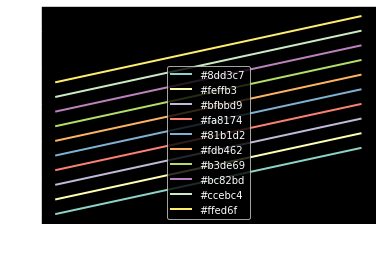

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, color in enumerate(colors):
    
    plt.plot(np.arange(0, 10, 1) + i * 2, 
             label=color, color=color, lw=2)

    plt.xlabel("Asset price")
    plt.ylabel("Monte-Carlo Probability")
    plt.legend()
    # plt.show()
    
prop_cycle

### FM Graph

In [281]:
import numpy as np

random_generator = np.random.default_rng()

factorization_matrix = random_generator.integers(0, 10, size=(6, 2))

factorization_matrix

array([[9, 8],
       [4, 2],
       [4, 6],
       [3, 1],
       [5, 5],
       [3, 4]])

In [282]:
coupling_matrix = factorization_matrix @ factorization_matrix.T

coupling_matrix

array([[145,  52,  84,  35,  85,  59],
       [ 52,  20,  28,  14,  30,  20],
       [ 84,  28,  52,  18,  50,  36],
       [ 35,  14,  18,  10,  20,  13],
       [ 85,  30,  50,  20,  50,  35],
       [ 59,  20,  36,  13,  35,  25]])

In [306]:
coupling_matrix = factorization_matrix @ factorization_matrix.T

coupling_matrix

array([[145,  52,  84,  35,  85,  59],
       [ 52,  20,  28,  14,  30,  20],
       [ 84,  28,  52,  18,  50,  36],
       [ 35,  14,  18,  10,  20,  13],
       [ 85,  30,  50,  20,  50,  35],
       [ 59,  20,  36,  13,  35,  25]])

In [284]:
graph = nx.from_numpy_matrix(coupling_matrix)

print(graph)

Graph with 6 nodes and 21 edges


In [285]:
weights = nx.get_edge_attributes(graph,'weight')

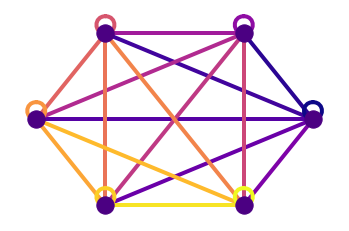

In [286]:
positions = nx.circular_layout(graph)

edge_colors = range(graph.number_of_edges())

plt.axis('off')
nx.draw_networkx(graph, positions, 
                 with_labels=False, 
                 edge_cmap=plt.cm.plasma, 
                 edge_color=edge_colors,
                 # node_size=0,
                 node_color='indigo',
                 width=4)